<a href="https://colab.research.google.com/github/sheethalkaran/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices/blob/main/milestone2/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [15]:
!pip install tsfresh prophet scikit-learn matplotlib seaborn --quiet

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from prophet import Prophet

In [34]:
df = pd.read_csv(
    "/content/drive/MyDrive/FitPulse/Milestone2/data/milestone2_reduced_fitness_data.csv"
)

df["DateTime"] = pd.to_datetime(df["DateTime"]).dt.tz_localize(None)
df.head()

,DateTime,Id,HeartRate,Steps,TotalMinutesAsleep
0,2016-04-12 00:00:00,4020332650,63.500000,0,501.0
1,2016-04-12 00:01:00,4020332650,65.913043,0,501.0
2,2016-04-12 00:02:00,4020332650,67.000000,0,501.0
3,2016-04-12 00:03:00,4020332650,67.000000,0,501.0
4,2016-04-12 00:04:00,4020332650,67.000000,0,501.0


In [35]:
print("Dataset shape:", df.shape)
print("Unique IDs:", df["Id"].nunique())

print("\nRows per ID:")
print(df.groupby("Id")["DateTime"].count())

print("\nMissing values:")
print(df.isna().sum())

Dataset shape: (75, 5)
Unique IDs: 5

Rows per ID:
Id
2022484408    15
2026352035    15
2347167796    15
4020332650    15
4388161847    15
Name: DateTime, dtype: int64

Missing values:
DateTime              0
Id                    0
HeartRate             0
Steps                 0
TotalMinutesAsleep    0
dtype: int64


In [36]:
ts_data = df[
    ["Id", "DateTime", "HeartRate", "Steps", "TotalMinutesAsleep"]
]

features = extract_features(
    ts_data,
    column_id="Id",
    column_sort="DateTime"
)

impute(features)
features.head()

Feature Extraction: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


,HeartRate__variance_larger_than_standard_deviation,HeartRate__has_duplicate_max,HeartRate__has_duplicate_min,HeartRate__has_duplicate,HeartRate__sum_values,HeartRate__abs_energy,HeartRate__mean_abs_change,HeartRate__mean_change,HeartRate__mean_second_derivative_central,HeartRate__median,...,TotalMinutesAsleep__fourier_entropy__bins_5,TotalMinutesAsleep__fourier_entropy__bins_10,TotalMinutesAsleep__fourier_entropy__bins_100,TotalMinutesAsleep__permutation_entropy__dimension_3__tau_1,TotalMinutesAsleep__permutation_entropy__dimension_4__tau_1,TotalMinutesAsleep__permutation_entropy__dimension_5__tau_1,TotalMinutesAsleep__permutation_entropy__dimension_6__tau_1,TotalMinutesAsleep__permutation_entropy__dimension_7__tau_1,TotalMinutesAsleep__query_similarity_count__query_None__threshold_0.0,TotalMinutesAsleep__mean_n_absolute_max__number_of_maxima_7
2022484408,1.0,0.0,0.0,1.0,1071.076190,79087.300867,5.673810,-2.126190,0.290171,73.000000,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2026352035,1.0,0.0,0.0,1.0,997.566667,66381.874444,0.845238,0.050000,-0.003846,66.800000,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,437.0
2347167796,1.0,0.0,0.0,0.0,1311.925289,116702.317258,3.813605,-2.178571,0.373077,84.571429,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4020332650,1.0,0.0,0.0,1.0,1004.789848,67434.006618,1.775934,0.107143,-0.092809,67.000000,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,501.0
4388161847,1.0,0.0,0.0,0.0,909.542857,55244.710567,1.685714,-0.190476,0.193223,61.600000,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [37]:
selector = VarianceThreshold(threshold=0.01)
features_selected = selector.fit_transform(features)

selected_features = features.loc[:, selector.get_support()]
selected_features.shape

(5, 647)

In [38]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(selected_features)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


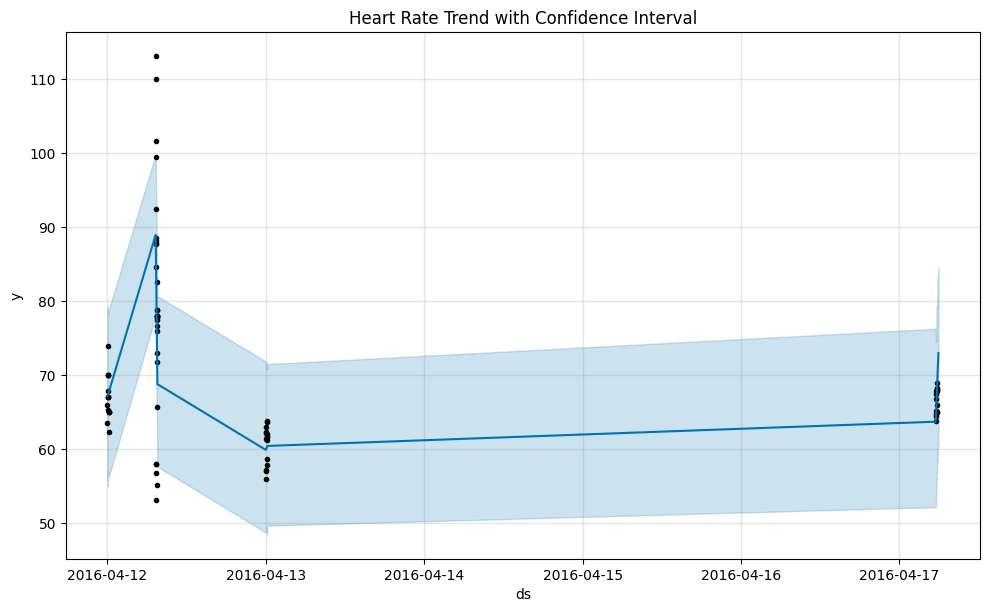

In [39]:
hr_df = df[["DateTime", "HeartRate"]].rename(
    columns={"DateTime": "ds", "HeartRate": "y"}
)

model_hr = Prophet()
model_hr.fit(hr_df)

future_hr = model_hr.make_future_dataframe(periods=10, freq="min")
forecast_hr = model_hr.predict(future_hr)

model_hr.plot(forecast_hr)
plt.title("Heart Rate Trend with Confidence Interval")
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


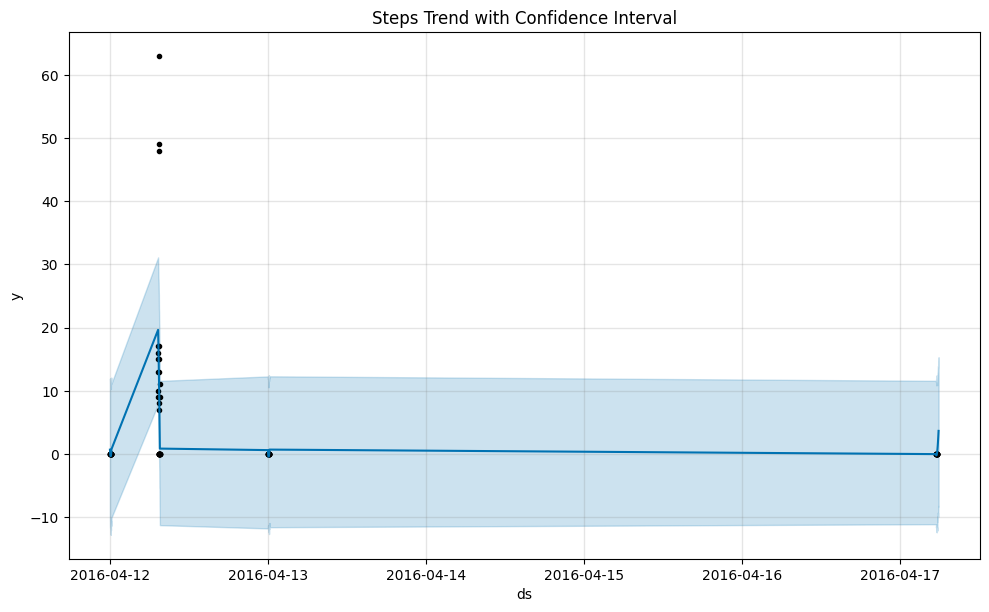

In [40]:
steps_df = df[["DateTime", "Steps"]].rename(
    columns={"DateTime": "ds", "Steps": "y"}
)

model_steps = Prophet()
model_steps.fit(steps_df)

future_steps = model_steps.make_future_dataframe(periods=10, freq="min")
forecast_steps = model_steps.predict(future_steps)

model_steps.plot(forecast_steps)
plt.title("Steps Trend with Confidence Interval")
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


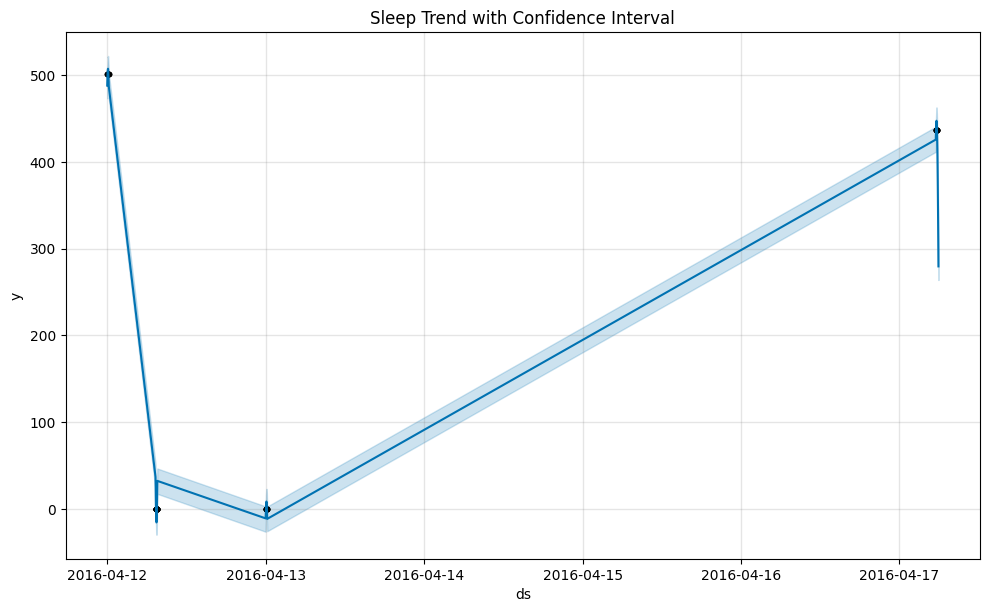

In [41]:
sleep_df = df[["DateTime", "TotalMinutesAsleep"]].rename(
    columns={"DateTime": "ds", "TotalMinutesAsleep": "y"}
)

model_sleep = Prophet()
model_sleep.fit(sleep_df)

future_sleep = model_sleep.make_future_dataframe(periods=10, freq="min")
forecast_sleep = model_sleep.predict(future_sleep)

model_sleep.plot(forecast_sleep)
plt.title("Sleep Trend with Confidence Interval")
plt.show()

In [42]:
hr_df["predicted"] = forecast_hr["yhat"][:len(hr_df)]
hr_df["residual"] = hr_df["y"] - hr_df["predicted"]
hr_df.head()

,ds,y,predicted,residual
0,2016-04-12 00:00:00,63.500000,67.208650,-3.708650
1,2016-04-12 00:01:00,65.913043,67.243131,-1.330088
2,2016-04-12 00:02:00,67.000000,67.277857,-0.277857
3,2016-04-12 00:03:00,67.000000,67.312899,-0.312899
4,2016-04-12 00:04:00,67.000000,67.348328,-0.348328


In [43]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(
    pca_features,
    columns=["PC1", "PC2"],
    index=features.index
)

pca_df.head()

,PC1,PC2
2022484408,-8.470608,-24.245829
2026352035,15.633283,7.026666
2347167796,-34.461151,11.872215
4020332650,16.237300,6.715432
4388161847,11.061176,-1.368484


In [44]:
kmeans = KMeans(n_clusters=2, random_state=42)
pca_df["KMeans_Cluster"] = kmeans.fit_predict(pca_features)

In [45]:
dbscan = DBSCAN(eps=1.5, min_samples=2)
pca_df["DBSCAN_Cluster"] = dbscan.fit_predict(pca_features)

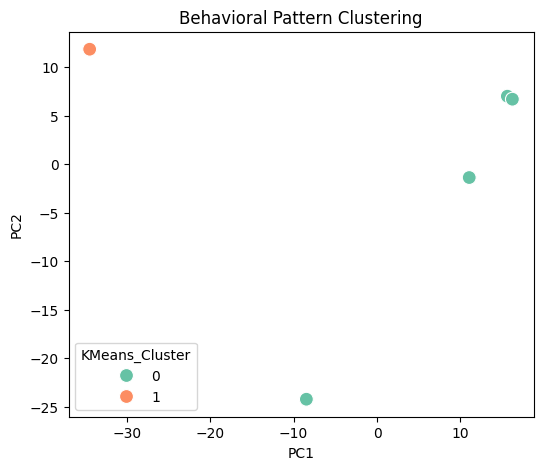

In [46]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="KMeans_Cluster",
    data=pca_df,
    palette="Set2",
    s=100
)
plt.title("Behavioral Pattern Clustering")
plt.show()

In [47]:
pca_df.groupby("KMeans_Cluster").mean()

,PC1,PC2,DBSCAN_Cluster
KMeans_Cluster,,,
0,8.615288,-2.968054,-0.5
1,-34.461151,11.872215,-1.0
